In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.api import VARMAX

In [42]:
data = pd.read_csv('https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv')
data['date'] = pd.to_datetime(data['time'])
dates = data['date']
start_index = 4000
end_index = 5426
# assuming i knew the supply change in advance as exogenuous regressor, used as feature with weekly diff
exog = data[['SplyAct1yr']].diff(7).fillna(0).values[start_index:end_index]
# further i use past prices and the hashrarte to predict future prices
data = data[['PriceUSD','HashRate']][start_index:end_index]
dates = dates[start_index:end_index]


/var/folders/0f/01zw64517cqdsbtf53d86j7h0000gn/T/ipykernel_26175/1769733749.py:1: DtypeWarning: Columns (146) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv')


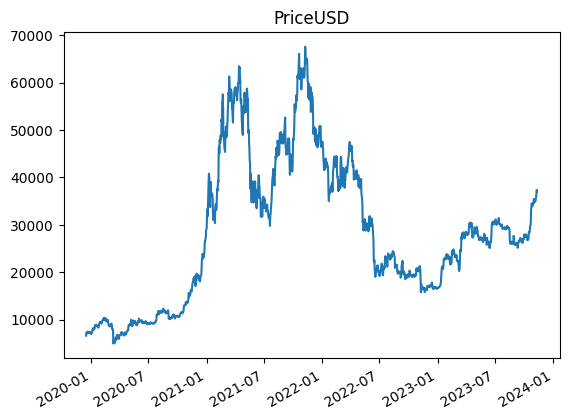

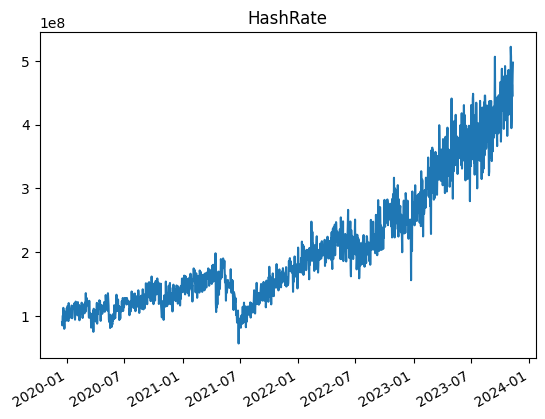

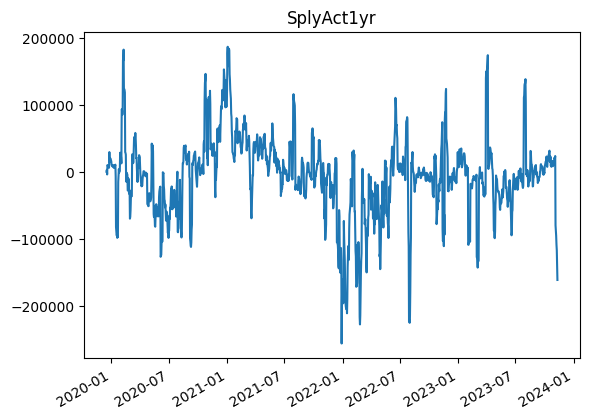

In [44]:
# plotting the data
plt.plot(dates,data.PriceUSD)
plt.title('PriceUSD')
plt.gcf().autofmt_xdate()
plt.show()

plt.plot(dates,data.HashRate)
plt.title('HashRate')
plt.gcf().autofmt_xdate()
plt.show()

plt.plot(dates,exog)
plt.title('SplyAct1yr')
plt.gcf().autofmt_xdate()
plt.show()

## VARMAX

$Y_t = c + \sum_{i=1}^{n} A_i Y_{t-i} + \sum_{j=1}^{m} B_j e_{t-j} + X_t \beta + e_t$

In [ ]:
# varmax' comoponents are
# a constant
# the sum of weighted lags for all time series known in the past
# the sum of weighted past errors for the considered lags
# the sum of available exogenuous variables for forecast date t
# random error

In [45]:
# lets have a train test split
train = data[:-100].values
test = data[-100:].values


# first explore a var model without the ma (error modeling) part with 4 lags
lag_order =  4
ma_order  =  0
model1 = VARMAX(train,order = (lag_order,ma_order))

# second, add error modeling
lag_order =  4
ma_order  =  4
model2 = VARMAX(train,order = (lag_order,ma_order))

# third, add an exogenuous regressor
lag_order =  4
ma_order  =  4
model3 = VARMAX(train,order = (lag_order,ma_order), exog = exog[:-100])

# fit the models

model1 = model1.fit(maxiter=30, disp=False)
model2 = model2.fit(maxiter=30, disp=False)
model3 = model3.fit(maxiter=30, disp=False)

# predict
horizon= 30
preds1 = model1.get_forecast(steps=horizon).predicted_mean
preds2 = model2.get_forecast(steps=horizon).predicted_mean
preds3 = model3.get_forecast(steps=horizon,exog = exog[-100:-100+horizon]).predicted_mean

/Users/leif/miniforge3/envs/nixtla/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/leif/miniforge3/envs/nixtla/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/leif/miniforge3/envs/nixtla/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/leif/miniforge3/envs/nixtla/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarni

In [49]:
# check out coefficients
model1.summary()

Dep. Variable:,"['y1', 'y2']",No. Observations:,1326
Model:,VAR(4),Log Likelihood,-35406.752
,+ intercept,AIC,70855.503
Date:,"Wed, 15 Nov 2023",BIC,70964.492
Time:,14:41:51,HQIC,70896.356
Sample:,0,,
,- 1326,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 1.04",Jarque-Bera (JB):,"1725.17, 558.55"
Prob(Q):,"0.97, 0.31",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.56, 6.39",Skew:,"-0.02, 0.16"


In [50]:
model2.summary()

Dep. Variable:,"['y1', 'y2']",No. Observations:,1326
Model:,"VARMA(4,4)",Log Likelihood,-35349.601
,+ intercept,AIC,70773.203
Date:,"Wed, 15 Nov 2023",BIC,70965.230
Time:,14:41:52,HQIC,70845.181
Sample:,0,,
,- 1326,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 0.03",Jarque-Bera (JB):,"1730.31, 497.66"
Prob(Q):,"0.97, 0.86",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.57, 5.74",Skew:,"-0.02, 0.27"


In [51]:
model3.summary()

Dep. Variable:,"['y1', 'y2']",No. Observations:,1326
Model:,"VARMAX(4,4)",Log Likelihood,-35360.043
,+ intercept,AIC,70798.086
Date:,"Wed, 15 Nov 2023",BIC,71000.493
Time:,14:41:52,HQIC,70873.955
Sample:,0,,
,- 1326,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.03, 3.09",Jarque-Bera (JB):,"1695.67, 491.59"
Prob(Q):,"0.85, 0.08",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.60, 5.88",Skew:,"-0.05, 0.26"


0.04000314584119788

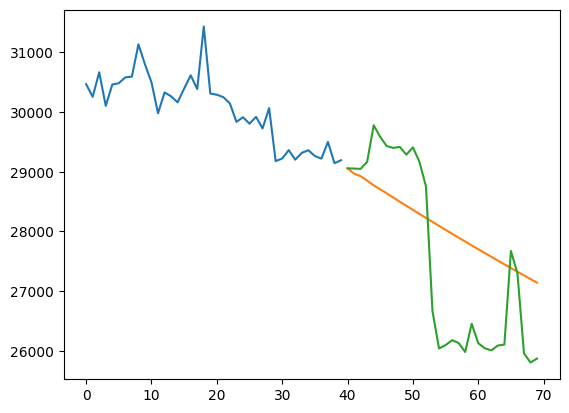

In [52]:
# plot forecast vs actual and cehck out error scores

show_past = 40
plt.plot(np.arange(0,show_past),train[-show_past:,0])
plt.plot(np.arange(show_past,show_past+horizon),preds1[:,0])
plt.plot(np.arange(show_past,show_past+horizon),test[:horizon,0])

# error in test 
mean_absolute_percentage_error(test[:horizon,0],preds1[:,0])

0.038239753118467605

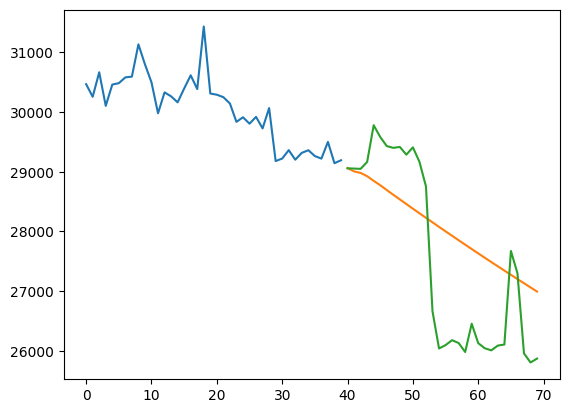

In [53]:
# error modeling improves a bit
show_past = 40
plt.plot(np.arange(0,show_past),train[-show_past:,0])
plt.plot(np.arange(show_past,show_past+horizon),preds2[:,0])
plt.plot(np.arange(show_past,show_past+horizon),test[:horizon,0])

mean_absolute_percentage_error(test[:horizon,0],preds2[:,0])

0.03718677298308913

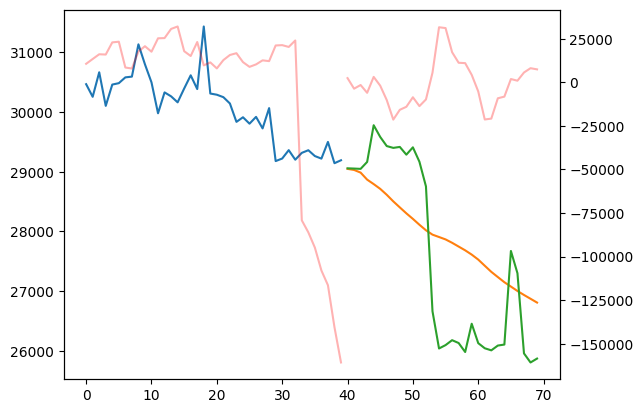

In [54]:
# extra regressor a bit more
show_past = 40
plt.plot(np.arange(0,show_past),train[-show_past:,0])
plt.plot(np.arange(show_past,show_past+horizon),preds3[:,0])
plt.plot(np.arange(show_past,show_past+horizon),test[:horizon,0])

ax2 = plt.twinx()
ax2.plot(np.arange(0,show_past),exog[-show_past:,0],color='red',alpha=0.3)
ax2.plot(np.arange(show_past,show_past+horizon),exog[-100:-100+horizon,0],color='red',alpha=0.3)

mean_absolute_percentage_error(test[:horizon,0],preds3[:,0])